In [1]:
# import required
import pandas as pd
import numpy as np

# Boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# Statistical analysis
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

In [2]:
# Load the dataset
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [3]:
print('Shape:', df.shape)

print('\nInfo:')
df.info()

# Missing values
print('\nMissing values:')
print(df.isnull().sum())

Shape: (8807, 12)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB

Missing values:
show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3


**Missing Values ​​Management**

In [4]:
# Replace NaN with 'Unknown' for specific columns
cols_fill_unknown = ['director', 'cast', 'country']
df[cols_fill_unknown] = df[cols_fill_unknown].fillna('Unknown')

# Convert 'date_added' to datetime
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')

# Drop rows with missing 'date_added', 'rating', or 'duration'
cols_drop = ['date_added', 'rating', 'duration']
df = df.dropna(subset=cols_drop)

# Verify
print('\nMissing values:')
print(df.isnull().sum())

print('\nDatetime type:', df['date_added'].dtype)


Missing values:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

Datetime type: datetime64[ns]


**Normalization**

In [5]:
# split "90 min" → 90, "2 Seasons" → 2
df['duration_num'] = df['duration'].str.extract(r'(\d+)').astype(int)
df['duration_unit'] = df['duration'].str.extract(r'([A-Za-z]+)')[0].str.lower()

# Verification
df[['duration', 'duration_num', 'duration_unit']].sample(5)

,duration,duration_num,duration_unit
7979,55 min,55,min
3219,1 Season,1,season
1192,24 min,24,min
7111,86 min,86,min
8666,95 min,95,min


**Outliers**

In [6]:
df.describe()

,date_added,release_year,duration_num
count,8702,8702.000000,8702.000000
mean,2019-05-23 17:46:40.735463168,2014.196736,70.605378
min,2008-01-01 00:00:00,1925.000000,1.000000
25%,2018-04-24 00:00:00,2013.000000,3.000000
50%,2019-07-12 00:00:00,2017.000000,89.000000
75%,2020-08-26 00:00:00,2019.000000,106.000000
max,2021-09-25 00:00:00,2021.000000,312.000000
std,NaN,8.829530,50.607863


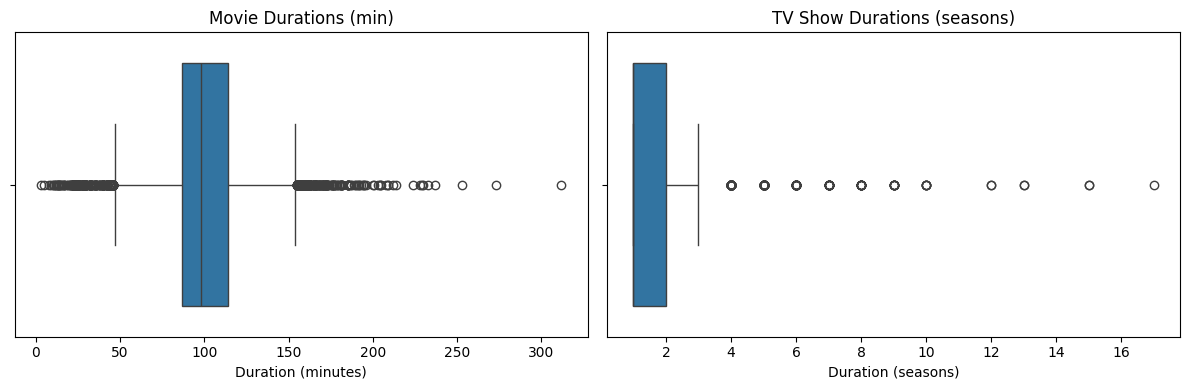

In [7]:
# Filter for movies and series separately
df_movies = df[df['duration_unit'] == 'min']
df_series = df[df['duration_unit'].str.contains('season')]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Boxplot for movie durations
sns.boxplot(x=df_movies['duration_num'], ax=axes[0])
axes[0].set_title("Movie Durations (min)")
axes[0].set_xlabel("Duration (minutes)")

# Boxplot for TV show durations
sns.boxplot(x=df_series['duration_num'], ax=axes[1])
axes[1].set_title("TV Show Durations (seasons)")
axes[1].set_xlabel("Duration (seasons)")

plt.tight_layout()
plt.show()


*To better understand the distribution of content durations, we split the original duration column into two separate features: a numeric value (**duration_num**) and its corresponding unit (**duration_unit**, either minutes for movies or seasons for series). This allowed us to analyze each type independently.*

*Boxplots revealed that most movies have durations between approximately **60 and 120 minutes**, while most TV shows span **1 to 3 seasons**. However, several outliers exist — for instance, a few movies are over 250 minutes long, and some series exceed 10 seasons.*

*These outliers were not removed, as they may represent valid entries, such as **long documentaries or long-running TV series**. Instead, they were kept in the dataset to preserve the full range of Netflix content.*

In [8]:
print('\nInfo:')
df.info()


Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8702 entries, 0 to 8806
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   show_id        8702 non-null   object        
 1   type           8702 non-null   object        
 2   title          8702 non-null   object        
 3   director       8702 non-null   object        
 4   cast           8702 non-null   object        
 5   country        8702 non-null   object        
 6   date_added     8702 non-null   datetime64[ns]
 7   release_year   8702 non-null   int64         
 8   rating         8702 non-null   object        
 9   duration       8702 non-null   object        
 10  listed_in      8702 non-null   object        
 11  description    8702 non-null   object        
 12  duration_num   8702 non-null   int64         
 13  duration_unit  8702 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(11)
memory usage: 1019.8+ KB


**Statistical analysis**

--> *Has the proportion of TV Shows increased over time?*

In [9]:
# Create a new column for the period
df['period'] = df['release_year'].apply(lambda x: 'Before 2015' if x < 2015 else 'After 2015')

# Build the contingency table
contingency_1 = pd.crosstab(df['period'], df['type'])

# Display the table to see what we’re working with
print(contingency_1)

#Is the distribution of Movie vs TV Show independent of the period?
chi2, p, dof, expected = chi2_contingency(contingency_1)

print(f"\nChi-square statistic: {chi2:.2f}")
print(f"P-value: {p:.4f}")

type         Movie  TV Show
period                     
After 2015    4013     2140
Before 2015   2113      436

Chi-square statistic: 269.35
P-value: 0.0000


*We performed a **Chi-square test** to examine whether **the distribution of content types (Movies vs. TV Shows) has changed over time**.*

*Since p < 0.05, we reject the null hypothesis.*

*Using a split at the year **2015**, the test revealed a significant association between release period and content type (χ² = 269.35, p < 0.0001).*

***This suggests that Netflix has significantly increased the proportion of TV Shows released since 2015, reflecting a strategic shift toward episodic content in recent years.***

________________________________________________________________________________________

--> *Do newer movies tend to be longer?*

In [10]:
# Filter to valid movie rows only
df_movie_duration = df[(df['type'] == 'Movie') & (df['duration_unit'] == 'min')]

# Drop missing or invalid values
df_movie_duration = df_movie_duration.dropna(subset=['release_year', 'duration_num'])

# Calculate Spearman correlation
corr, p_val = spearmanr(df_movie_duration['release_year'], df_movie_duration['duration_num'])

print(f"Spearman correlation: {corr:.3f}")
print(f"P-value: {p_val:.4f}")

Spearman correlation: -0.191
P-value: 0.0000


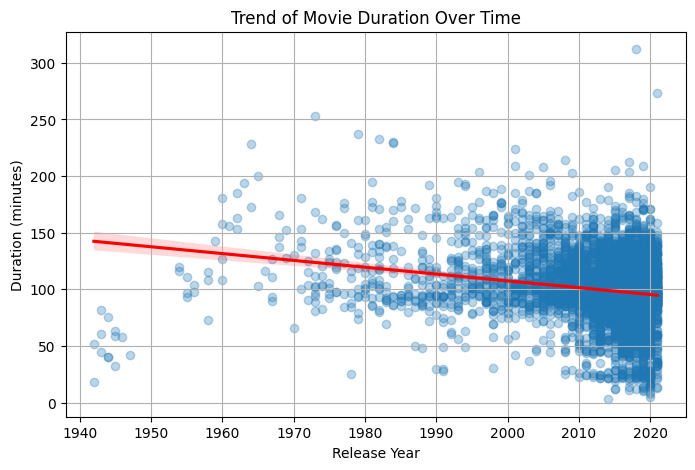

In [11]:
# Create the plot
plt.figure(figsize=(8, 5))
sns.regplot(x='release_year', y='duration_num', data=df_movie_duration, scatter_kws={'alpha':0.3}, line_kws={"color":"red"})

plt.title("Trend of Movie Duration Over Time")
plt.xlabel("Release Year")
plt.ylabel("Duration (minutes)")
plt.grid(True)
plt.show()

*We analyzed the relationship between movie release year and duration using **Spearman correlation**, which is appropriate for ordinal or non-linear trends.*

*The result showed a weak but statistically significant negative correlation (ρ = –0.191, p < 0.0001), indicating that **newer movies tend to be slightly shorter than older ones**. This may reflect changing audience preferences or shifts in production strategy on streaming platforms like Netflix, focusing on episodic content.*

In [12]:
# Save the cleaned DataFrame to a new CSV
df.to_csv('netflix_titles_cleaned.csv', index=False)
